# Case study: Find COVID-19's spatial impacts on mobility in France

In this case, we use REST APIs of ODT Explorer to analyze the COVID-19 impacts on mobility among administrative regions in France.

## Import packages

In [106]:
import os
import math
import pandas as pd
import numpy as np
import requests
from io import StringIO
import keplergl
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from keplergl import KeplerGl

## Read the boundary file

<AxesSubplot:>

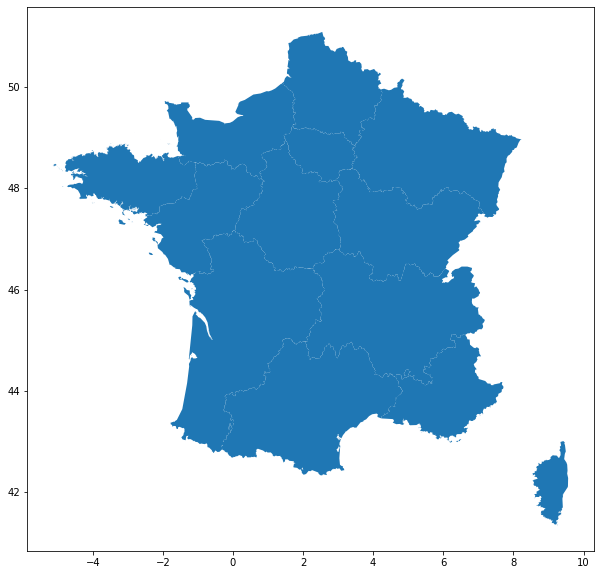

In [10]:
subdivision_file = r'gadm01_simplified/gadm36_1.shp'

gdf = gpd.read_file(subdivision_file)

# set the target place  
target_place = r'FRA'       # Fine the 3-digit country code here: https://countrycode.org/

# show the map of target place
gdf_country = gdf[gdf['GID_1'].str[:3] == target_place]
gdf_country.plot(figsize=(20, 10))

## obtain 2020 flow data using REST APIs of ODT Explorer

In [131]:
params = {"operation": "get_daily_movement_for_all_places",
          "scale": "world_first_level_admin",
          "source": "twitter",
          "begin": "01/01/2020",
          "end": "12/31/2020"
      }

q = r'http://gis.cas.sc.edu/GeoAnalytics/REST'
r = requests.get(q, params=params)
df = pd.read_csv(StringIO(r.text))

# extract flows of the target place
df = df[df['place'].str[:3] == target_place]

# replace place codes with place names
df = pd.merge(df, gdf_country[['GID_1', "NAME_1"]], left_on='place', right_on="GID_1")
df['place'] = df['NAME_1']
df = df.drop(["NAME_1", "GID_1"], axis=1)

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,place,intra_movement
date,,
2020-01-01,Nouvelle-Aquitaine,199
2020-01-02,Nouvelle-Aquitaine,202
2020-01-03,Nouvelle-Aquitaine,203
2020-01-04,Nouvelle-Aquitaine,200
2020-01-05,Nouvelle-Aquitaine,217
...,...,...
2020-12-26,Normandie,88
2020-12-27,Normandie,80
2020-12-28,Normandie,72


## Draw a map showing the monthly change compared with January

Group the monthly flows of each administrative region.

In [132]:
groupped = df.groupby([pd.Grouper(freq='M'), 'place'] )['intra_movement'].sum().to_frame()
groupped

intra_movement
date       place                                     
2020-01-31 Auvergne-Rhône-Alpes                 11767
           Bourgogne-Franche-Comté               2156
           Bretagne                              3663
           Centre-Val de Loire                   3178
           Corse                                  651
...                                               ...
2020-12-31 Nouvelle-Aquitaine                    4884
           Occitanie                             4098
           Pays de la Loire                      2578
           Provence-Alpes-Côte d'Azur            5189
           Île-de-France                        29055

[156 rows x 1 columns]

Extract the flows of January

In [125]:
dates = groupped.index.get_level_values("date").unique()
jan_data = groupped.loc[dates[0]]   ## dates[0].strftime("%Y-%m-%d")
jan_data

,intra_movement
place,
Auvergne-Rhône-Alpes,11767
Bourgogne-Franche-Comté,2156
Bretagne,3663
Centre-Val de Loire,3178
Corse,651
Grand Est,8250
Hauts-de-France,13015
Normandie,4431
Nouvelle-Aquitaine,7272


Show the map.

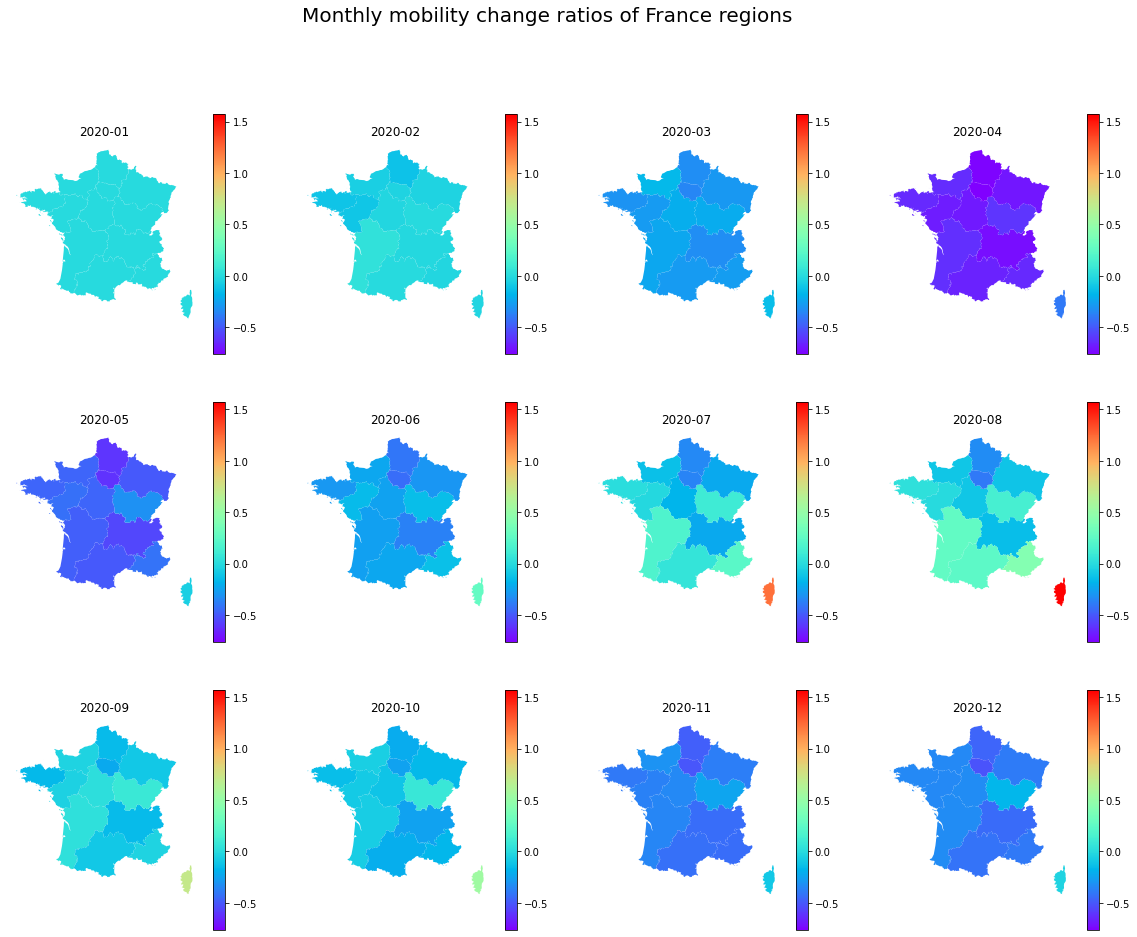

In [140]:
row_cnt = 3
col_cnt = 4
fig, axes = plt.subplots(row_cnt, col_cnt, figsize=(20,15))
fig.suptitle("Monthly mobility change ratios of France regions", fontsize=20) 


# find the range of monthly changes
changes = groupped.groupby(level=[0, 1])['intra_movement'].sum() / jan_data['intra_movement']- 1
vmin= min(changes)
vmax= max(changes)

# draw suplots
for idx, date in enumerate(dates):
    month_df = groupped.loc[date]
    axes[divmod(idx, col_cnt)].axis('off')

    month_df['adjusted'] = (month_df['intra_movement'].to_list() - jan_data['intra_movement']) / jan_data['intra_movement']

    re = gdf_country.set_index('NAME_1').join(month_df, how='left')
    re.plot(column=re['adjusted'], 
            cmap='rainbow',  
            ax=axes[divmod(idx, col_cnt)], 
            legend=True, 
            vmin=vmin,
            vmax=vmax,                       
           )
    axes[divmod(idx, col_cnt)].set_title(date.strftime("%Y-%m"))

plt.show()

## Plot the monthly data

Plot all regions together

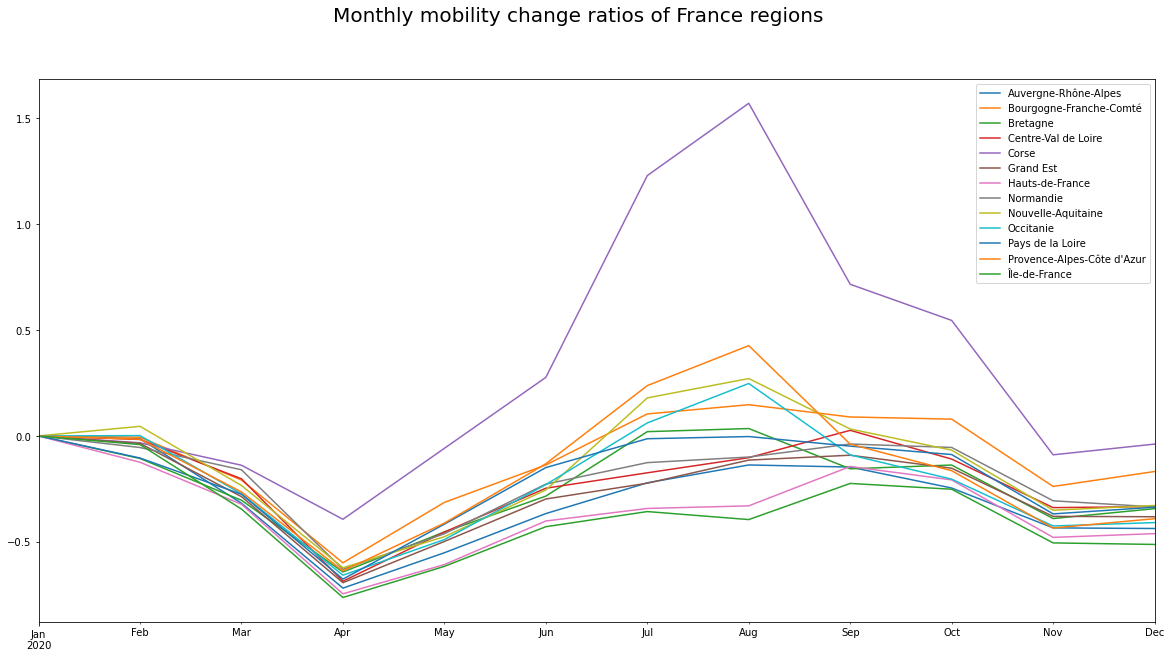

In [141]:
groupped = df.groupby([pd.Grouper(freq='M'), 'place'], as_index=True )['intra_movement'].sum().to_frame()
changes = groupped.groupby(level=[0, 1])['intra_movement'].sum() / jan_data['intra_movement']- 1

fig, ax = plt.subplots()
fig.suptitle("Monthly mobility change ratios of France regions", fontsize=20) 
ax = changes.unstack(level=1).plot(figsize=(20, 10), ax=ax)
ax.set(xlabel="")
ax.legend(groupped.unstack(level=1).columns.get_level_values(1));

Plot  regions individually

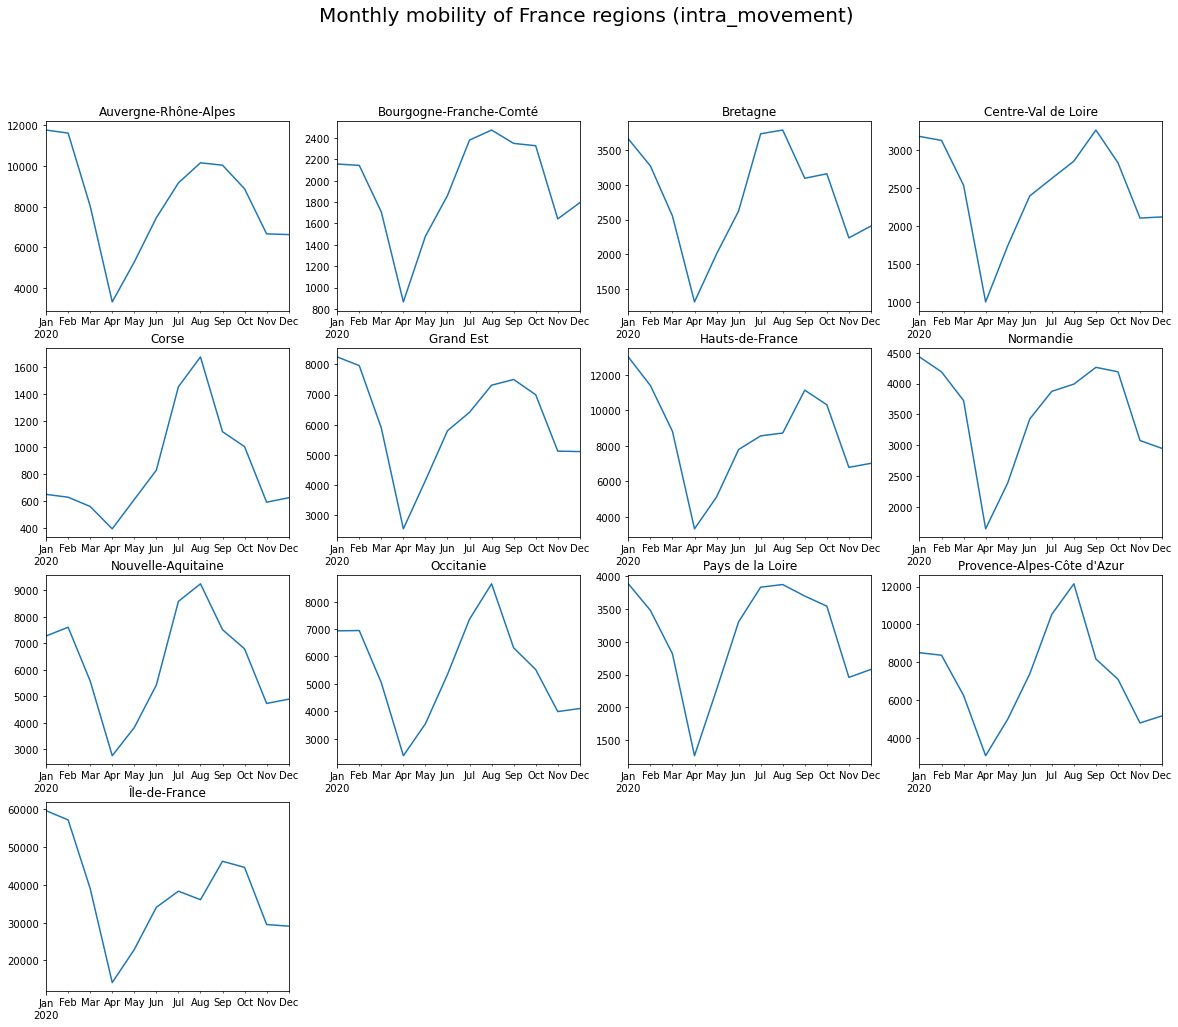

In [145]:
groupped = df.groupby([pd.Grouper(freq='M'), 'place'] )['intra_movement'].sum().to_frame()
groupped = groupped.reorder_levels(['place', "date"])
places = groupped.index.get_level_values("place").unique()
col_cnt = min(6, math.ceil(math.sqrt(len(places))))
row_cnt = math.ceil(len(places)/col_cnt)
fig, axes = plt.subplots(row_cnt, col_cnt, figsize=(row_cnt * 5, col_cnt * 4) )
fig.suptitle("Monthly mobility of France regions (intra_movement)", fontsize=20) 

for idx, place in enumerate(places):
    day_df = groupped.loc[place]
    ax = day_df.plot(ax=axes[divmod(idx, col_cnt)], title = place, legend=False)
    ax.set_xlabel("")

for i in range(idx + 1, col_cnt * row_cnt, 1):
    axes[divmod(i, col_cnt)].axis('off')

plt.show()